### Assignment 2 - Text Classification
> นาย วศิน เสริมสัมพันธ์ 60070157

### Import Libraby & Init url

In [174]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
# Model
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.datasets import load_files
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, ShuffleSplit
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# display progress bar (tqdm>=4.23.4 | pandas==0.24.0)
from tqdm import tqdm_notebook as tqdm 

#evaluaitotn 
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

In [143]:
# make sure you download words set in the first time
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [168]:
# init request
baseUrl = "http://www.it.kmitl.ac.th/~teerapong/news_archive"
homeUrl = "http://www.it.kmitl.ac.th/~teerapong/news_archive/index.html"
response = requests.get(homeUrl)

### <font color=blue>Extract Month URL</font>
> extract all month url and collect into `month_url_group`

In [145]:
# parse html
soup = BeautifulSoup(response.text, "html.parser", from_encoding="utf-8")

c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\bs4\__init__.py:191: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


In [146]:
# create month url
li_group = soup.findAll('li')
month_url_group = [f"{baseUrl}/{li.find('a')['href']}" for li in li_group]

### <font color=blue> Extract Article Properties</font>
> extract article properties such as `category (for anser)`, `title`, `article_url` and collec into array <br>
_for ensure that each type of article properties is in the same position, we check by use size of array_

In [154]:
# use url each month to fetch article
article_category = []
article_title = []
article_url = []

for month in month_url_group: # loop each month 

    # init soup
    month_resp = requests.get(month);
    soup = BeautifulSoup(month_resp.text, "html.parser", from_encoding="utf-8")
    
    # append category
    category_group = soup.findAll('td', {'class': 'category'});
    for category in category_group:
        # article category not available -> skip
        if category.getText().strip() == "N/A": continue
        article_category.append(category.getText().strip())
        
    # append title & url
    title_group = soup.findAll('td', {'class': 'title'});
    for title in title_group:
        # article title not available -> skip
        if title.getText().strip() == "Article no longer available in archive": continue
        article_title.append(title.getText().strip())
        article_url.append(f"{baseUrl}/{title.find('a')['href']}")

        
# display article properties length (check length is match)
print("Category: " + str(len(article_category)))
print("Title: " + str(len(article_title)))
print("Url: " + str(len(article_url)))

Category: 1408
Title: 1408
Url: 1408


#### Category
- Buisiness
- Technology
- Sport


In [153]:
#  list of category
for i in set(article_category): print(i)

business
technology
sport


### <font color=blue> Extract Article Content</font>
> - we use `tqdm` package for build progress bar for a fresher overview of this process
- get url from article_url and request into server then find a `p` element for body content
- use `while True` for retry request when connection is block by server


In [155]:
# use articule url to fetch article content
article_content = []

with tqdm(total=len(article_url)) as pbar: # init progress bar
    

    for article in article_url:  # loop each article
        
        while True: # try again if conneciton is block
            
            try: # catch content not avaliable

                article_resp = requests.get(article);
                soup = BeautifulSoup(article_resp.text, "html.parser", from_encoding="utf-8")
                current_content = []

                article_group = soup.findAll('p')
                for content in article_group[:-1]:

                    # check <p> is empty?
                    if (content.text == ""): continue
                    current_content.append(content.text.rstrip("\n\r"))

                # join each <p> to raw string and append to article_content
                article_content.append(''.join(current_content))

            except:
                print(current_content + "\n")
                continue
                
            # update progress bar
            pbar.update(1)
            
            break;

# display article content length
print("Content: " + str(len(article_content)))


Content: 1408


### <font color=blue> Save files </font>
> save each type of article into txt file 

In [57]:
# write article_title.txt
with open("./datastore/article_title.txt", "w", encoding="utf-8") as file:
    for row in article_title:
        file.write("%s\n" % row)
    file.close()

# write article_category.txt
with open("./datastore/article_category.txt", "w", encoding="utf-8") as file:
    for row in article_category:
        file.write("%s\n" % row)
    file.close()
    
# write article_content.txt
with open("./datastore/article_content.txt", "w", encoding="utf-8") as file:
    for row in article_content:
        file.write("%s\n" % row)
    file.close()

### <font color=blue> Read files </font>
> if you don't want to scraping article you can skip scraping step by run these code

In [3]:
# read article_title.txt
with open("./datastore/article_title.txt", "r", encoding="utf-8") as file:
    title_raw = file.read().splitlines()
    file.close()
    
with open("./datastore/article_category.txt", "r", encoding="utf-8") as file:
    category_raw = file.read().splitlines()
    file.close()
    
# read article_title.txt
with open("./datastore/article_content.txt", "r", encoding="utf-8") as file:
    content_raw = file.read().splitlines()
    file.close()

In [158]:
# noting lel XD
title_data = title_raw
content_data = content_raw
category_data = category_raw

### <font color=blue> Text Preprogrssion </font>
>- remove special charectors and numbers from text
- convert charectos to lowercase
- reduce word to root, base  
- if you have error `IOPub data rate exceeded.` run notebook with `jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10` in terminal

In [5]:
documents = []
stemmer = WordNetLemmatizer()
for content in content_data:
    # remove all the special characters
    document = re.sub(r'\W', ' ', str(content))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)
  
# show example
print("original: " + content_data[0] + "\n")
print("after process: " + documents[0])

original: The sporting industry has come a long way since the â60s. It has carved out for itself a niche with its roots so deep that I cannot fathom the sports industry showing any sign of decline any time soon - or later.The reason can be found in this seemingly subtle difference - other industries have customers; the sporting industry has fans. Vivek RanadivÃ©, leader of the ownership group of the NBAâs Sacramento Kings, explained it beautifully, âFans will paint their face purple, fans will evangelize. ... Every other CEO in every business is dying to be in our position â theyâre dying to have fans.âWhile fan passion alone could almost certainly keep the industry going, leagues and sporting franchises have decided not to rest on their laurels. The last few years have seen the steady introduction of technology into the world of sports - amplifying fansâ appreciation of games, enhancing athletesâ public profiles and informing their training methods, even influencing ho

### <font color=blue> Converting Text </font>
> - we use `TFIDF` to find the importance of term in a document by looking at its weight

#### TF (Term frequency )
measure the frequency of term in document

In [159]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  # with bow

# word counts for the words 
bow_process = vectorizer.fit_transform(documents).toarray()
bow_process.shape # 1500 uniqe word 

(1408, 1500)

#### IDF (Inverse document frequency)
measure the importance of term in all documents. This means that if term is found in many documents, it will be less important

In [160]:
tfidfconverter = TfidfTransformer()
tfidf = tfidfconverter.fit_transform(bow_process).toarray()

### <font color=blue> Modeling </font>
> - Split data to test and train
- Tuning each model by use GridSearchCV and RandomSearchCV(for many params)
- Fit the model by use best params
- Predict test
- Evaluation Model

#### Model list
- Random Forest
- Naive Bayes
- SGD
- LogisticRegression

In [53]:

X_train, X_test, y_train, y_test = train_test_split(tfidf, category_data, test_size=0.2, random_state=0)

### Random Forest Model

In [54]:
# init model
rf = RandomForestClassifier()

>tuning

In [55]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features to consider at every split
max_features = ['auto', 'sqrt']
# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# show list of params for tuning
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [115]:
# use RandomSearchCV to tuning model random forest
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=5, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [161]:
# get best estimator for voting classifier
rf_best = rf_random.best_estimator_
# show best paramst
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

> predict

In [162]:
# predict by use data test
rf_predicted = rf_random.predict(X_test)

> evaluation

              precision    recall  f1-score   support

    business       0.97      0.96      0.96        95
       sport       0.96      0.98      0.97       108
  technology       0.96      0.95      0.96        79

    accuracy                           0.96       282
   macro avg       0.96      0.96      0.96       282
weighted avg       0.96      0.96      0.96       282

Accuracy = 0.9645%.


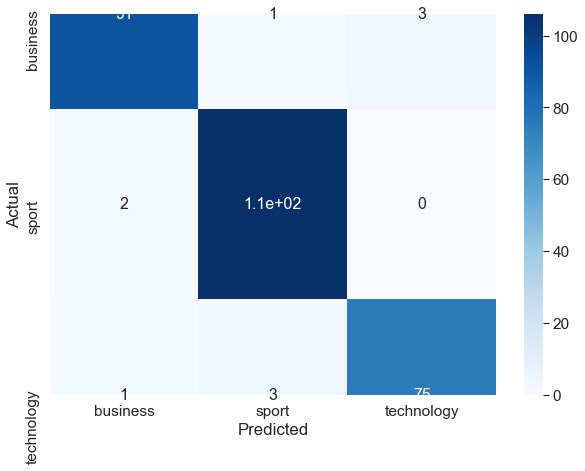

In [163]:
print(classification_report(y_test,rf_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, rf_predicted)))

# plot confustion matrix
# if graph is wrong that means it's up to your sklearn version.
data = confusion_matrix(y_test, rf_predicted)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

### Naive Bayes classifier 

In [164]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
nb_clf_predicted = nb_clf.predict(X_test)

              precision    recall  f1-score   support

    business       0.97      0.98      0.97        95
       sport       0.98      0.97      0.98       108
  technology       0.97      0.97      0.97        79

    accuracy                           0.98       282
   macro avg       0.97      0.98      0.98       282
weighted avg       0.98      0.98      0.98       282

Accuracy = 0.9752%.


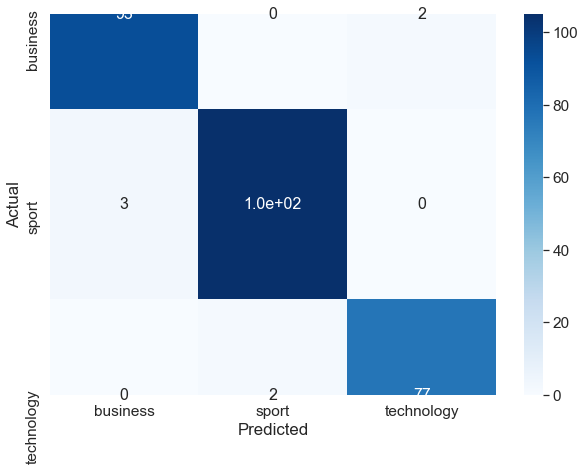

In [165]:
print(classification_report(y_test,nb_clf_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, nb_clf_predicted)))

data = confusion_matrix(y_test, nb_clf_predicted)

df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

### Kneighbor classifier 

In [59]:
knn = KNeighborsClassifier()

#### tuning

In [216]:
# init parans for  tuning
params_knn = {'n_neighbors': np.arange(1, 22)}

# use gridsearch to test all values for n_neighbors (tuning)
knn_gs = GridSearchCV(knn, params_knn, cv=3, verbose=5, n_jobs = -1) # cross-validate with 3

# fit model to training data
knn_gs.fit(X_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:   30.8s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [218]:
knn_best = knn_gs.best_estimator_
# show best paramst
knn_gs.best_params_

{'n_neighbors': 9}

#### predict

In [220]:
kn_predicted = knn_gs.predict(X_test)

#### evaluation

              precision    recall  f1-score   support

    business       0.98      0.96      0.97        95
       sport       0.98      0.98      0.98       108
  technology       0.96      0.99      0.97        79

    accuracy                           0.98       282
   macro avg       0.97      0.98      0.97       282
weighted avg       0.98      0.98      0.98       282

Accuracy = 0.9752%.


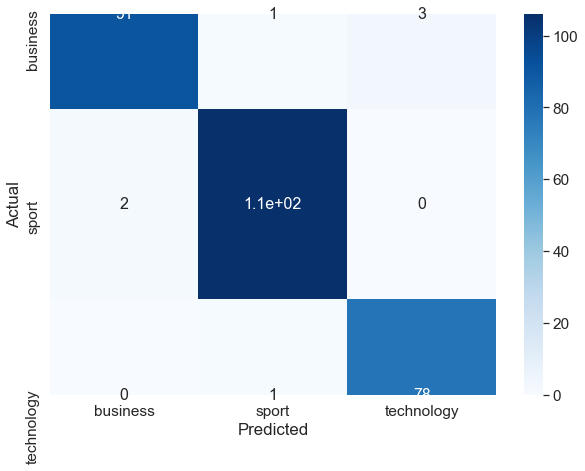

In [63]:
print(classification_report(y_test,kn_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, kn_predicted)))

data = confusion_matrix(y_test, kn_predicted)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

### SGDClassifier (Optional test)

In [64]:
sgd = SGDClassifier()

#### tuning

In [122]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], "penalty": ["none", "l1", "l2"]}

In [123]:
sgd_gs = GridSearchCV(sgd, param_grid=grid, cv=3, verbose=5, n_jobs = -1)
sgd_gs.fit(X_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    6.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['none', 'l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score

In [227]:
sgd_best = sgd_gs.best_estimator_

# show best params
sgd_gs.best_params_

{'alpha': 0.001, 'penalty': 'l2'}

In [228]:
sgd_gs_predicted = sgd_gs.predict(X_test)

              precision    recall  f1-score   support

    business       0.97      0.99      0.98        95
       sport       0.99      0.97      0.98       108
  technology       0.99      0.99      0.99        79

    accuracy                           0.98       282
   macro avg       0.98      0.98      0.98       282
weighted avg       0.98      0.98      0.98       282

Accuracy = 0.9823%.


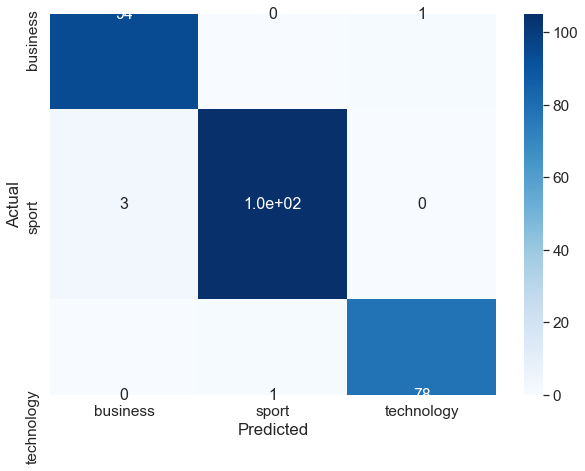

In [230]:
print(classification_report(y_test,sgd_gs_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, sgd_gs_predicted)))


data = confusion_matrix(y_test, sgd_gs_predicted)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

### LogisticRegression

In [125]:
lr = LogisticRegression()

#### tuning

In [126]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
lr_gs=GridSearchCV(lr, grid,cv=3, verbose=5, n_jobs = -1)
lr_gs.fit(X_train,y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    2.9s finished
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [128]:
lr_best = lr_gs.best_estimator_

# show best params
lr_gs.best_params_

{'C': 100.0, 'penalty': 'l2'}

In [129]:
lr_gs_predicted = lr_gs.predict(X_test)

#### evalution

              precision    recall  f1-score   support

    business       0.97      0.99      0.98        95
       sport       0.99      0.97      0.98       108
  technology       0.99      0.99      0.99        79

    accuracy                           0.98       282
   macro avg       0.98      0.98      0.98       282
weighted avg       0.98      0.98      0.98       282

Accuracy = 0.9823%.


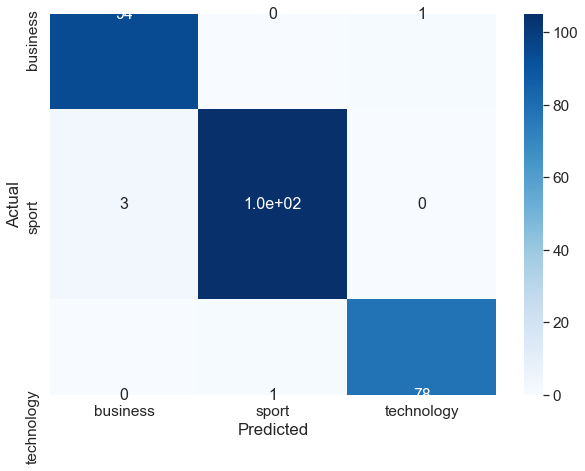

In [130]:
print(classification_report(y_test,lr_gs_predicted))
print('Accuracy = {:0.4f}%.'.format(accuracy_score(y_test, lr_gs_predicted)))


data = confusion_matrix(y_test, lr_gs_predicted)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

# Conclusion

> `Logistic Regression` and `SGD (for test)` has the highest accuracy of 0.9823% Therefore, we use the logistic regression model.
> ###  <font color=red>Logistic Regression</font> is the winner!~
> ### <font color=red>Accuracy 0.9823%</font>

In [252]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,  n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'c:\\users\\user\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

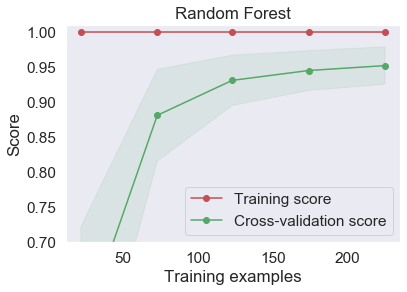

In [253]:
plot_learning_curve(rf_best, 'Random Forest', X_test, y_test, (0.7, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from 'c:\\users\\user\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

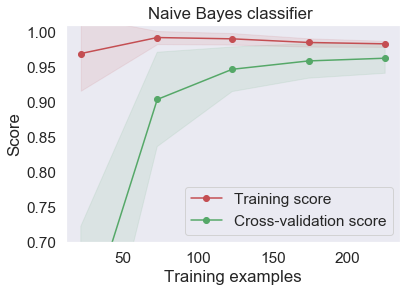

In [212]:
plot_learning_curve(nb_clf, 'Naive Bayes classifier ', X_test, y_test, (0.7, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from 'c:\\users\\user\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

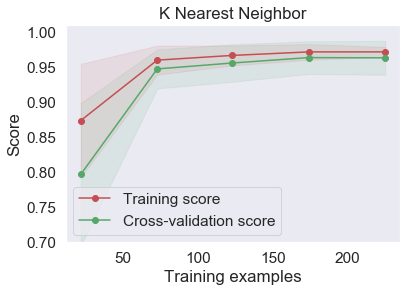

In [222]:
plot_learning_curve(knn_best, 'K Nearest Neighbor', X_test, y_test, (0.7, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from 'c:\\users\\user\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

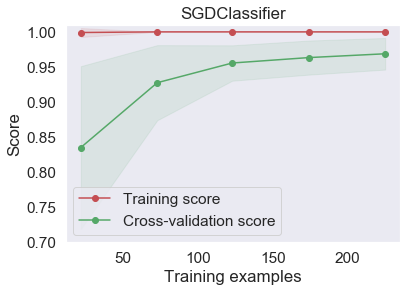

In [231]:
plot_learning_curve(sgd_best, 'SGDClassifier', X_test, y_test, (0.7, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from 'c:\\users\\user\\appdata\\local\\programs\\python\\python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

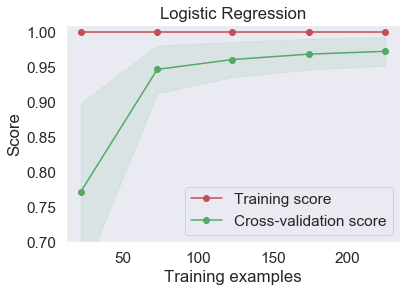

In [232]:
plot_learning_curve(lr_best, 'Logistic Regression', X_test, y_test, (0.7, 1.01), cv=cv, n_jobs=4)

### Voting Classifer
ensemble model makes the prediction by majority vote, use 4 different models to to put into voting classifer

In [166]:
estimators=[('knn', knn_best), ('rf', rf_best), ('log_reg', lr_best), ('nb', nb_clf), ('sgd', sgd_best)]

#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard') # predicitons by majority vote

#fit model to training data
ensemble.fit(X_train, y_train) #test model on the test data
ensemble.score(X_test, y_test)

c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9787234042553191